In [1]:
import time
import gzip, os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Conv2D,Dropout,MaxPooling2D
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image, ImageFilter

In [2]:
def save_run_history(history, save_path='./results/run_history.png'):
  """
    This helps to save the model training history results

    Parameter(s):
      history : history object
      save_path : where to save the reports
  """
  plt.figure(figsize=(14,8))
  plt.subplot(1, 2, 1)
  plt.suptitle('Training Results', fontsize=15)
  plt.ylabel('Loss', fontsize=12)
  plt.xlabel("#Epochs")
  plt.plot(history.history['loss'], color='blue', label='Training Loss')
  plt.plot(history.history['val_loss'], color='red', label='Validation Loss')
  plt.legend(loc='upper right')

  plt.subplot(1, 2, 2)
  plt.ylabel('Accuracy', fontsize=12)
  plt.xlabel("#Epochs")
  plt.plot(history.history['accuracy'], color='green', label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], color='orange', label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.savefig(save_path, facecolor='white')
  plt.close()
  print("Training history plots saved in results.")
  
  
def save_confusion_matrix(y_true, y_pred, class_labels, save_path='./results/confusion_matrix.png'):
  """
    This helps to save the confusion matrix for the trained model
  
    Parameter(s):
      y_true : true classes
      y_pred : predicted classes
      class_labels : class labels list, where index is the class
      save_path : where to save the reports
  """
  plt.figure(figsize=(14, 8))
  conf_matrix = np.round(confusion_matrix(y_true, y_pred, normalize='true'), 1)
  df_cm = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
  hMap = sns.heatmap(df_cm, annot=True)
  plt.xlabel('Predicted Label')
  plt.ylabel('Actual Label')
  plt.savefig(save_path, facecolor='white')
  plt.close()
  print("Confusion Matrix saved in results.")
  
  
def save_classification_report(y_true, y_pred, class_labels, save_path='./results/classification_report.txt'):
  """
    This helps to save the classification report for the trained model

    Parameter(s):
      y_true : true classes
      y_pred : predicted classes
      class_labels : class labels list, where index is the class
      save_path : where to save the reports
  """
  with open(save_path,'w') as cr:
    cr.write(classification_report(y_true, y_pred, target_names=class_labels))
  print("Classification report saved in results.")


def process_image(img_path, img_dims=(28,28)):
  """
    This function reads any image and processes it into a pixel values after converting 
    it into a grayscale version .

    Parameter(s):
      img_path : path of image file
      img_dims : dimensions pf image (width x height)
  """
  image = Image.open(img_path).convert('L')
  img_w, img_h = map(float, image.size)
  # creates white canvas of 28x28 pixels, or any other specified value
  new_image = Image.new('L', img_dims, (255))

  if img_w > img_h:
      # width is greater so it is fixed to 20 pixels and the height is adjusted acccordingly.
      new_w, new_h = 20, max(1, int(round((20.0 / img_w*img_h), 0)))
      # calculate horizontal and vertical positions
      wleft, wtop = 4, int(round(((img_dims[1] - new_h) / 2), 0))
  else:
      # height is greater/equal so it is fixed to 20 pixels and the width is adjusted acccordingly.
      new_w, new_h = max(1, int(round((20.0 / img_w*img_h), 0))), 20
      # calculate horizontal and vertical positions
      wleft, wtop = int(round(((img_dims[0] - new_w) / 2), 0)), 4

  img = image.resize((new_w, new_h), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
  # resized image is pasted after centering it on the newly created white canvas
  new_image.paste(img, (wleft, wtop))

  # get pixel values
  new_image_arr = list(new_image.getdata())
  return new_image_arr


def load_image_data(filepath):
  """
    Load the idx image data from given path

    Parameter(s):
      filepath : path to the image dataset file
  """
  with gzip.open(filepath, 'rb') as img_dataset:
    images = np.frombuffer(img_dataset.read(), dtype=np.uint8, offset=16)
  return images


def load_label_data(filepath):
  """
    Load the idx label data from given path

    Parameter(s):
      filepath : path to the label dataset file
  """
  with gzip.open(filepath, 'rb') as lb_dataset:
    labels = np.frombuffer(lb_dataset.read(), dtype=np.uint8, offset=8)
  return labels


In [3]:
class MyCallback(tf.keras.callbacks.Callback):
  def __init__(self, epochs):
    super().__init__()
    self.epochs = epochs
    
  def on_epoch_begin(self, epoch, logs=None):
    if epoch == 0:
      self.start_time = time.time()
      print("Epoch 1 in progress..", end='\r')
    else:
      time_elapsed = time.time() - self.start_time
      eta = (time_elapsed/epoch) * (self.epochs-epoch)/60.0
      print("Training ETA : %.1f min(s)" %eta, end='\r')
  
  def on_train_end(self, logs=None):
    print("Training Completed..               ")

In [4]:
class ImageClassifier(object):
  """
    Class carrying all the functionalities for CNN based image classification 
    and prediction
  """
  def __init__(self, img_dim=(28, 28)):
    """
      Parameter(s):
        img_dim : (width, height)
    """
    assert len(img_dim)==2, "Image dimensions should be in form (width, height)"
    self.IMG_W, self.IMG_H = img_dim
    self._cnn_model = None
  
  
  def _preprocess_data(self, images_arr, labels_arr=None):
    """
      Take the images and labels data and return the scaled and reshaped form

      Parameter(s):
        images_arr : list of images data of shape (samples,img_h,img_w)
        labels_arr : list of labels data of shape (samples,)
    """
    images_arr = images_arr.reshape(-1, self.IMG_H, self.IMG_W, 1)
    images_arr = (255.0 - images_arr) / 255.0
    # images_arr = images_arr / 255.0
    if labels_arr is not None:
      labels_arr = to_categorical(labels_arr, num_classes=len(set(labels_arr)))
    return images_arr, labels_arr
  
  
  def load_from_raw_data(self, train_images_path, train_labels_path, test_images_path, test_labels_path,
                     class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 
                                    'Shirt', 'Sneaker', 'Bag', 'Ankle boot']):
    """
      Load image and labels data in pixel value format. Returns the train, validation and 
      test set, after preprocessing.
      
      Parameter(s):
        train_images_path, train_labels_path, test_images_path, test_labels_path
        class_labels : labels for each class values
    """
    assert os.path.isfile(train_images_path), "Images training data missing"
    assert os.path.isfile(train_labels_path), "Labels training data missing"
    assert os.path.isfile(test_images_path), "Images test data missing"
    assert os.path.isfile(test_labels_path), "Labels test data missing"
    
    # Load images
    train_images = load_image_data(train_images_path).reshape(-1, self.IMG_H, self.IMG_W)
    test_images = load_image_data(test_images_path).reshape(-1, self.IMG_H, self.IMG_W)
    
    # Load labels
    train_labels = load_label_data(train_labels_path)
    test_labels = load_label_data(test_labels_path)
    
    # Split training data for training and validation
    train_images, val_images, train_labels, val_labels = train_test_split(train_images, 
                                          train_labels, test_size=0.25, random_state=123)
    
    # Preprocess the image data by scaling and categorizing
    self._train_images, self._train_labels = self._preprocess_data(train_images, train_labels)
    self._val_images, self._val_labels = self._preprocess_data(val_images, val_labels)
    self._test_images, self._test_labels = self._preprocess_data(test_images, test_labels)
    self._class_labels = class_labels
    print("Data loaded successfully.")
  
  
  def load_from_image_files(self, data_dir):
    """
      Load image and labels data from raw images, where each class of images are kept in
      their respective directories, having directory name as class names. 
      Returns the train, validation and test set, after preprocessing.
      
      Parameter(s):
        data_dir : folder of images data
    """
    assert os.path.isdir(data_dir), "Image directory is not valid"
    
    images_arr, labels_arr, class_labels = list(), list(), list()
    for fi,folder in enumerate(os.listdir(data_dir)):
      success, total = 0, 0
      class_labels.append(folder.title())
      for file in os.listdir(os.path.join(data_dir, folder)):
        try:
          img_arr = process_image(os.path.join(data_dir,folder,file))
          images_arr.append(img_arr)
          labels_arr.append(fi)
          success += 1
        except:
          print("Error in processing file: %s" %(os.path.join(data_dir,folder,file)))
        finally:
          total += 1
      print("%d out of %d images processed for label - %s" %(success, total, folder.title()))
    self._class_labels = class_labels
    
    images_arr, labels_arr = np.array(images_arr), np.array(labels_arr)
    # Split training data for training, validation and testing
    train_images, val_images, train_labels, val_labels = train_test_split(images_arr, 
                                  labels_arr, test_size=0.30, stratify=labels_arr, random_state=123)
    val_images, test_images, val_labels, test_labels = train_test_split(val_images, 
                                  val_labels, test_size=0.30, stratify=val_labels, random_state=123)
    
    # Re-shape
    train_images = train_images.reshape(-1, self.IMG_H, self.IMG_W)
    val_images = val_images.reshape(-1, self.IMG_H, self.IMG_W)
    test_images = test_images.reshape(-1, self.IMG_H, self.IMG_W)
    
    # Preprocess the image data by scaling and categorizing
    self._train_images, self._train_labels = self._preprocess_data(train_images, train_labels)
    self._val_images, self._val_labels = self._preprocess_data(val_images, val_labels)
    self._test_images, self._test_labels = self._preprocess_data(test_images, test_labels)
    print("Data loaded successfully.")
  
    
  def _create_cnn_model(self):
    """
      Defines and returns the CNN model
    """
    cnn_model = Sequential()
    cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', 
                                                 input_shape=(self.IMG_W, self.IMG_H, 1)))
    cnn_model.add(MaxPooling2D((2, 2)))
    cnn_model.add(Dropout(0.25))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    cnn_model.add(Dense(len(self._class_labels), activation='softmax'))
    
    cnn_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    return cnn_model
  
  
  def train(self, save_dir='./model'):
    """
      Train the CNN model
      
      Parameter(s):
        save_dir : directory where you want the model to be saved after training. 
                    Pass None if you want to train just for checking
    
    """
    assert self._class_labels is not None, "Class labels not defined"
    
    self._cnn_model = self._create_cnn_model()
    print("Training initiated..")
    history = self._cnn_model.fit(self._train_images, self._train_labels, batch_size=256, 
                                 epochs=10, verbose=0, callbacks=[MyCallback(10)],
                                 validation_data=(self._val_images, self._val_labels))
    
    # Print and save history if specified
    print("Training Loss : %.3f" % history.history['loss'][-1])
    print("Validation Loss : %.3f" % history.history['val_loss'][-1])
    print("Training Accuracy : %.3f" % history.history['accuracy'][-1])
    print("Validation Accuracy : %.3f" % history.history['val_accuracy'][-1])
    
    if save_dir is not None:
      save_run_history(history)
      self._cnn_model.save(save_dir)
    
    score = self._cnn_model.evaluate(self._test_images, self._test_labels, verbose=0)
    print("Test Loss : %.3f" % score[0])
    print("Test Accuracy : %.3f" % score[1])
    
    if save_dir is not None:
      y_true = self._test_labels.argmax(axis=1)
      y_pred = np.argmax(self._cnn_model.predict(self._test_images), axis=-1)
      save_confusion_matrix(y_true, y_pred, self._class_labels)
      save_classification_report(y_true, y_pred, self._class_labels)
  
  
  def predict_from_raw_data(self, images_path):
    """
      Load image data given in pixel value format from the file and return the predicted labels.
      
      Parameter(s):
        images_path
    """
    assert os.path.isfile(images_path), "Images data file missing"
    assert self._cnn_model is not None, "Model training has not been done"
    
    # Load images
    images_data = load_image_data(images_path).reshape(-1, self.IMG_H, self.IMG_W)
    images_data,_ = self._preprocess_data(images_data)
    classes = np.argmax(self._cnn_model.predict(images_data), axis=-1)
    labels = list(map(lambda i:self._class_labels[i], classes))
    return labels
  
  
  def predict_from_image_files(self, data_dir):
    """
      Load image data from the image files and return the predicted labels.
      
      Parameter(s):
        data_dir : location of images
    """
    assert os.path.isdir(data_dir), "Image directory is not valid"
    assert self._cnn_model is not None, "Model training has not been done"
    
    error_index, images_arr = dict(), list()
    for fi,file in enumerate(os.listdir(data_dir)):
      try:
        img_arr = process_image(os.path.join(data_dir,file))
        images_arr.append(img_arr)
      except Exception as ex:
        print("Error in processing file: %s : %s" %(os.path.join(data_dir,file), str(ex)))
        error_index[fi] = True
    
    images_arr = np.array(images_arr).reshape(-1, self.IMG_H, self.IMG_W)
    images_arr,_ = self._preprocess_data(images_arr)
    classes = np.argmax(self._cnn_model.predict(images_arr), axis=-1).tolist()
    
    # prepare labels from classes
    labels = list()
    for ci in range(len(classes)+len(error_index)):
      if error_index.get(ci) is not None:
        labels.append('Unknown')
      else:
        labels.append(self._class_labels[classes.pop(0)])
    return labels
  
  
  def load_trained_model(self, model_dir='./model/', class_labels = ['T-shirt/top', 'Trouser', 
                                                     'Pullover', 'Dress', 'Coat', 'Sandal', 
                                                   'Shirt', 'Sneaker', 'Bag', 'Ankle boot']):
    """
      Load image data from the image files and return the predicted labels.
      
      Parameter(s):
        model_dir : directory of saved model
        class_labels : labels of class values
    """
    try:
      self._cnn_model = tf.keras.models.load_model(model_dir)
      self._class_labels = class_labels
    except:
      print("Model could not be loaded.")    

In [5]:
img_clf = ImageClassifier()

In [6]:
img_clf.load_trained_model()

In [9]:
# img_clf.load_from_raw_data(train_images_path, train_labels_path, test_images_path, test_labels_path)

Data loaded successfully.


In [10]:
# img_clf.load_from_image_files('../data/test/')

In [11]:
img_clf.train()

Training initiated..
Training Completed..               
Training Loss : 0.123
Validation Loss : 0.253
Training Accuracy : 0.955
Validation Accuracy : 0.914
Training history plots saved in results.
INFO:tensorflow:Assets written to: ./model/assets
Test Loss : 0.256
Test Accuracy : 0.916
Confusion Matrix saved in results.
Classification report saved in results.


In [8]:
img_clf.predict_from_image_files('../data/test/trousers/')

['Trouser',
 'Trouser',
 'Trouser',
 'Trouser',
 'Trouser',
 'Trouser',
 'Trouser',
 'Trouser',
 'Trouser',
 'Trouser']

In [8]:
train_images_path = '../data/fashion/train-images-idx3-ubyte.gz'
train_labels_path = '../data/fashion/train-labels-idx1-ubyte.gz'
test_images_path = '../data/fashion/t10k-images-idx3-ubyte.gz'
test_labels_path = '../data/fashion/t10k-labels-idx1-ubyte.gz'

In [3]:
IMG_H, IMG_W = 28, 28

### Data Loading and Visualization

In [4]:
def load_image_data(filepath):
  """
    Load the idx image data from given path
    
    Parameter(s):
      filepath : path to the image dataset file
  """
  with gzip.open(filepath, 'rb') as img_dataset:
    images = np.frombuffer(img_dataset.read(), dtype=np.uint8, offset=16)
  return images

In [5]:
def load_label_data(filepath):
  """
    Load the idx label data from given path
    
    Parameter(s):
      filepath : path to the label dataset file
  """
  with gzip.open(filepath, 'rb') as lb_dataset:
    labels = np.frombuffer(lb_dataset.read(), dtype=np.uint8, offset=8)
  return labels

In [6]:
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [7]:
def display_image(image_matrix):
  """
    Display the given image 
    
    Parameter(s):
      image_matrix : 28x28 pixel values matrix
  """
  plt.figure(figsize=(1,1))
  image = np.asarray(image_matrix)
  plt.imshow(image, cmap=plt.cm.binary, interpolation='nearest')
  plt.axis('off')
  plt.show()

In [8]:
# Load images
train_images = load_image_data(train_images_path).reshape(-1, IMG_H, IMG_W)
test_images = load_image_data(test_images_path).reshape(-1, IMG_H, IMG_W)

In [9]:
# Load labels
train_labels = load_label_data(train_labels_path)
test_labels = load_label_data(test_labels_path)

In [10]:
train_images.shape, test_images.shape, train_labels.shape, test_labels.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

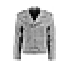

Coat


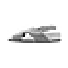

Sandal


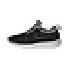

Sneaker


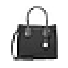

Bag


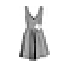

Dress


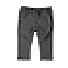

Trouser


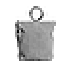

Bag


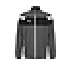

Coat


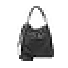

Bag


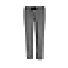

Trouser


In [11]:
# Display some random items
for img_id in np.random.choice(len(train_images), 10, replace=False):
  display_image(train_images[img_id])
  print(class_labels[train_labels[img_id]])
  print('='*50)

### EDA

In [12]:
np.unique(train_labels, return_counts=True)
# Labels are balanced

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

In [13]:
train_images.max(), train_images.min()
# scaling will be required

(255, 0)

### Data pre-processing

In [14]:
def preprocess_data(images_arr, labels_arr):
  """
    Take the images and labels data and return the scaled and reshaped form
    
    Parameter(s):
      images_arr : list of images data of shape (samples,img_h,img_w)
      labels_arr : list of labels data of shape (samples,)
  """
  images_arr = images_arr.reshape(-1, IMG_H, IMG_W, 1)
  # images_arr = (255.0 - images_arr) / 255.0
  images_arr = images_arr/255.0
  labels_arr = to_categorical(labels_arr, num_classes=len(class_labels))
  return images_arr, labels_arr

In [15]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, 
                                                                      train_labels, 
                                                                      test_size=0.25, 
                                                                      random_state=123)

In [16]:
train_images, train_labels = preprocess_data(train_images, train_labels)
val_images, val_labels = preprocess_data(val_images, val_labels)
test_images, test_labels = preprocess_data(test_images, test_labels)

### Model Building

In [17]:
def create_cnn_model():
  """
    Defines and returns the CNN model
  """
  cnn_model = Sequential()
  cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', 
                       kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  cnn_model.add(MaxPooling2D((2, 2)))
  cnn_model.add(Dropout(0.25))
  cnn_model.add(Flatten())
  cnn_model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  cnn_model.add(Dense(len(class_labels), activation='softmax'))
  
  cnn_model.compile(optimizer='adam',
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])
  
  return cnn_model

In [18]:
cnn_model = create_cnn_model()

In [21]:
history = cnn_model.fit(train_images, train_labels, batch_size=256, epochs=10, verbose=2, 
                        validation_data=(val_images, val_labels))

Epoch 1/10
176/176 - 25s - loss: 0.9274 - accuracy: 0.7204 - val_loss: 0.4043 - val_accuracy: 0.8603
Epoch 2/10
176/176 - 24s - loss: 0.3738 - accuracy: 0.8668 - val_loss: 0.3738 - val_accuracy: 0.8671
Epoch 3/10
176/176 - 26s - loss: 0.3311 - accuracy: 0.8819 - val_loss: 0.3465 - val_accuracy: 0.8769
Epoch 4/10
176/176 - 30s - loss: 0.3046 - accuracy: 0.8918 - val_loss: 0.3249 - val_accuracy: 0.8843
Epoch 5/10
176/176 - 30s - loss: 0.2900 - accuracy: 0.8963 - val_loss: 0.3048 - val_accuracy: 0.8915
Epoch 6/10
176/176 - 32s - loss: 0.2719 - accuracy: 0.9029 - val_loss: 0.3098 - val_accuracy: 0.8923
Epoch 7/10
176/176 - 41s - loss: 0.2573 - accuracy: 0.9087 - val_loss: 0.3011 - val_accuracy: 0.8941
Epoch 8/10
176/176 - 34s - loss: 0.2469 - accuracy: 0.9116 - val_loss: 0.2858 - val_accuracy: 0.9016
Epoch 9/10
176/176 - 34s - loss: 0.2332 - accuracy: 0.9162 - val_loss: 0.2896 - val_accuracy: 0.8978
Epoch 10/10
176/176 - 38s - loss: 0.2247 - accuracy: 0.9180 - val_loss: 0.2804 - val_accura

In [19]:
cnn_model = tf.keras.models.load_model('./model/')

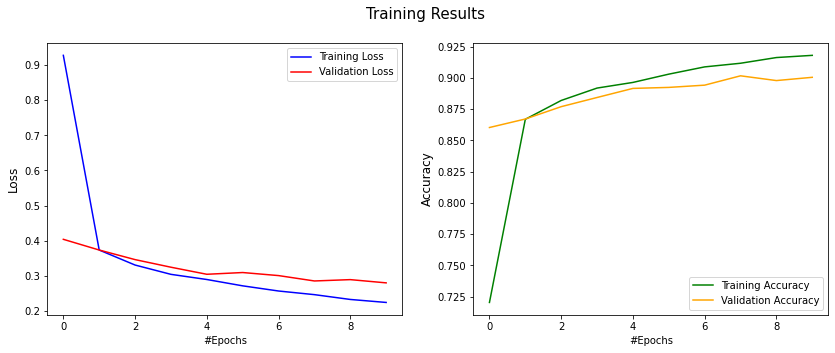

In [22]:
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.suptitle('Training Results', fontsize=15)
plt.ylabel('Loss', fontsize=12)
plt.xlabel("#Epochs")
plt.plot(history.history['loss'], color='blue', label='Training Loss')
plt.plot(history.history['val_loss'], color='red', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel("#Epochs")
plt.plot(history.history['accuracy'], color='green', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [23]:
score = cnn_model.evaluate(test_images, test_labels, verbose=0)

In [24]:
score

[0.28547152876853943, 0.8977000117301941]

In [27]:
np.argmax(cnn_model.predict(test_images[:2]), axis=-1).tolist()

[9, 2]

In [31]:
class_labels[np.argmax(cnn_model.predict(np.array([image_arr])), axis=None, out=None)]

'Trouser'